# Imports

In [1]:
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.layers import LSTM , Dropout , Dense
from tensorflow.keras.models import Sequential
import pandas_datareader.data as web
import datetime

import datetime
import pandas as pd 
import matplotlib.pyplot as plt

## Data 

Here we are collecting data from yahoo finance using web API in OHLCV format from 1st of jan 2011 till 
12th of april 2021

In [2]:
start = datetime.datetime(2011 , 1 , 1)
end= datetime.datetime.now()
df = web.DataReader('AXISBANK.NS' , 'yahoo' , start , end)

**Let's check the first 10 and last 10 rows in our data**

In [3]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,274.399994,268.459991,273.000000,273.529999,5266100.0,252.557571
2011-01-04,275.320007,268.700012,274.579987,269.589996,6919075.0,248.919693
2011-01-05,270.200012,260.600006,270.200012,262.179993,8749390.0,242.077789
2011-01-06,264.420013,260.000000,263.269989,261.170013,3967170.0,241.145233
2011-01-07,260.070007,252.779999,260.070007,256.130005,12047915.0,236.491699
2011-01-10,261.000000,249.259995,257.000000,250.919998,8070285.0,231.681137
2011-01-11,265.100006,252.000000,252.020004,260.040009,12543110.0,240.101898
2011-01-12,264.570007,258.000000,261.190002,262.670013,12960200.0,242.530243
2011-01-13,265.519989,252.220001,261.700012,253.089996,5724240.0,233.684769


In [4]:
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-26,707.000000,693.150024,707.000000,698.200012,13143312.0,698.200012
2021-03-30,713.299988,691.000000,705.000000,695.349976,25965218.0,695.349976
2021-03-31,703.549988,692.099976,696.000000,697.450012,14924620.0,697.450012
2021-04-01,717.000000,695.549988,706.299988,713.000000,13090326.0,713.000000
2021-04-05,708.450012,677.450012,707.200012,685.250000,16239521.0,685.250000
2021-04-06,693.500000,675.500000,690.099976,677.900024,12062011.0,677.900024
2021-04-07,691.900024,668.400024,680.500000,688.250000,14433515.0,688.250000
2021-04-08,695.500000,679.349976,691.500000,681.599976,9026398.0,681.599976
2021-04-09,686.799988,667.000000,679.299988,668.200012,12509114.0,668.200012


**Adding columns for moving average of 5 days and rsi for 14 days and after than removing the null values**

In [5]:
df['ma 5'] = df['Close'].rolling(5).mean()

In [6]:
def RSI(data , periods = 14):
    delta = data['Close'].diff()
    delta.fillna(0 , inplace=True)
    UP , DOWN = delta.copy(), delta.copy()
    UP[UP < 0] = 0
    DOWN[DOWN > 0 ] = 0
    
    rUP = UP.rolling(window=periods).mean()
    rDOWN = DOWN.abs().rolling(window=periods).mean()
    
    RS = rUP / rDOWN
    
    return (100.0 - (100.0 / (1.0 + RS)))

In [7]:
df['RSI'] = RSI(df)

In [10]:
df.dropna(inplace=True)

**Droping the Volume and Adj Close column , because we don't need that**

In [11]:
df.drop(['Volume' , 'Adj Close'] , axis=1 , inplace=True)

data = df.copy()

## Visualization 

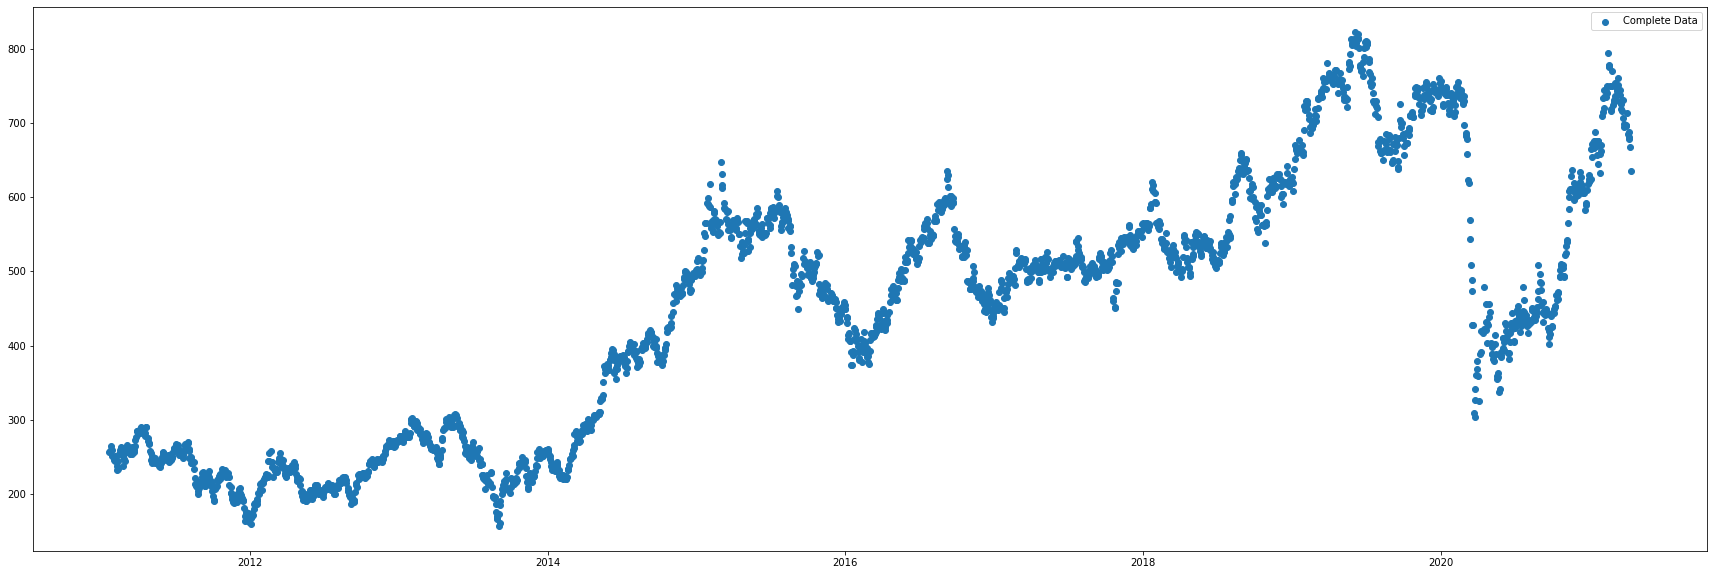

In [13]:
plt.figure(figsize=(30 , 10))
plt.scatter(df.index , df['Close'] , label='Complete Data')
plt.legend()
plt.show()

## Data Split

In [14]:
# Training and testing data
train_size = int(len(data) *0.80)
train = data[:train_size]
test = data[train_size :]

## Scaling the data 
Scaling the data between 0 and 1 .

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(np.array(train['Close']).reshape(-1,1))

In [16]:
scaled_open = scaler.transform(np.array(train['Open']).reshape(-1,1))
scaled_high = scaler.transform(np.array(train['High']).reshape(-1,1))
scaled_low = scaler.transform(np.array(train['Low']).reshape(-1,1))
scaled_ma = scaler.transform(np.array(train['ma 5']).reshape(-1,1))
scaled_rsi = scaler.transform(np.array(train['RSI']).reshape(-1,1))

In [17]:
open_list = []
close_list = []
high_list = []
low_list = []
ma_list = []
rsi_list = []
for i in range(len(scaled_open)):
    open_list.append(scaled_open[i])
    high_list.append(scaled_high[i])
    low_list.append(scaled_low[i])
    close_list.append( scaled_close[i])
    ma_list.append( scaled_ma[i])
    rsi_list.append( scaled_rsi[i])

In [18]:
open_arr = np.array(open_list).reshape(-1,1)
high_arr = np.array(high_list).reshape(-1,1)
low_arr = np.array(low_list).reshape(-1,1)
close_arr = np.array(close_list).reshape(-1,1)
ma_arr = np.array(ma_list).reshape(-1,1)
rsi_arr = np.array(rsi_list).reshape(-1,1)

In [19]:
scaled_data = pd.DataFrame(open_arr , columns=['Open'])

In [20]:
scaled_data['High'] = high_arr
scaled_data['Low'] = low_arr
scaled_data['Close'] = close_arr
scaled_data['ma 5'] = ma_arr
scaled_data['rsi'] = rsi_arr

In [21]:
scaled_train = np.array(scaled_data)

## Training Data

Preparing training data using OHLC of last 60 days 

In [22]:
X_train = []
y_train = []

for x in range(60,len(scaled_train)-1):
    temp = []
    for i in scaled_train[x-60 :x,]:
        temp.append(i[0] )
        temp.append(i[1])
        temp.append(i[2])
        temp.append(i[3])
        temp.append(i[4])
        temp.append(i[5])
        
    X_train.append(temp)
    
    y_train.append(scaled_train[x+1][3])

In [27]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [28]:
test_scaled_close = scaler.transform(np.array(test['Close']).reshape(-1,1))
test_scaled_open = scaler.transform(np.array(test['Open']).reshape(-1,1))
test_scaled_high = scaler.transform(np.array(test['High']).reshape(-1,1))
test_scaled_low = scaler.transform(np.array(test['Low']).reshape(-1,1))
test_scaled_ma = scaler.transform(np.array(test['ma 5']).reshape(-1,1))
test_scaled_rsi = scaler.transform(np.array(test['RSI']).reshape(-1,1))

In [33]:
open_list = []
close_list = []
high_list = []
low_list = []
ma_list = []
rsi_list= []
for i in range(len(test_scaled_open)):
    open_list.append(test_scaled_open[i])
    high_list.append(test_scaled_high[i])
    low_list.append(test_scaled_low[i])
    close_list.append( test_scaled_close[i])
    ma_list.append( test_scaled_ma[i])
    rsi_list.append( test_scaled_rsi[i])

In [34]:
open_arr = np.array(open_list).reshape(-1,1)
high_arr = np.array(high_list).reshape(-1,1)
low_arr = np.array(low_list).reshape(-1,1)
close_arr = np.array(close_list).reshape(-1,1)
ma_arr = np.array(ma_list).reshape(-1,1)
rsi_arr = np.array(rsi_list).reshape(-1,1)

In [35]:
scaled_data = pd.DataFrame(open_arr , columns=['Open'])
scaled_data['High'] = high_arr
scaled_data['Low'] = low_arr
scaled_data['Close'] = close_arr
scaled_data['ma 5'] = ma_arr
scaled_data['RSI'] = rsi_arr

In [36]:
scaled_test = np.array(scaled_data)

## Testing Data

Preparing the testing data to test our model

In [37]:
X_test = []
y_test = []

for x in range(60,len(scaled_test)-1):
    temp = []
    for i in scaled_test[x-60 :x,]:
        temp.append(i[0] )
        temp.append(i[1])
        temp.append(i[2])
        temp.append(i[3])
        temp.append(i[4])
        temp.append(i[5])
        
    X_test.append(temp)
    
    y_test.append(scaled_test[x+1][3])

In [38]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [42]:
X_train = X_train.reshape((-1,360 , 1))
y_train = y_train.reshape(-1,1)
X_test = X_test.reshape((-1,360,1))
y_train = y_train.reshape(-1,1)

## Model
Preparing the LONG-SHORT TERM MEMORY  model using 360 neurons 

In [43]:
lstm = Sequential()
lstm.add(LSTM(360 ,return_sequences=True ,  input_shape=(360,1)))
lstm.add(LSTM(360 , return_sequences = True))
lstm.add(LSTM(360))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error' , optimizer='adam' , metrics=['accuracy','mse'])

In [44]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360, 360)          521280    
_________________________________________________________________
lstm_1 (LSTM)                (None, 360, 360)          1038240   
_________________________________________________________________
lstm_2 (LSTM)                (None, 360)               1038240   
_________________________________________________________________
dense (Dense)                (None, 1)                 361       
Total params: 2,598,121
Trainable params: 2,598,121
Non-trainable params: 0
_________________________________________________________________


In [47]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='./models/lstmAxisBankmaRsi/',
                                              save_weights_only=True,
                                              verbose=1)

## Model Training

In [48]:
lstm.fit(X_train ,y_train , validation_data=(X_test,y_test) ,epochs=100 , batch_size=64 ,verbose=1 , callbacks=[callback] )

Epoch 1/100
31/31 [==============================] - 208s 7s/step - loss: 0.1221 - accuracy: 0.0010 - mse: 0.1221 - val_loss: 0.0055 - val_accuracy: 0.0000e+00 - val_mse: 0.0055

Epoch 00001: saving model to ./models/lstmAxisBankmaRsi/
Epoch 2/100
31/31 [==============================] - 208s 7s/step - loss: 0.0023 - accuracy: 0.0010 - mse: 0.0023 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 0.0022

Epoch 00002: saving model to ./models/lstmAxisBankmaRsi/
Epoch 3/100
31/31 [==============================] - 209s 7s/step - loss: 6.6813e-04 - accuracy: 0.0010 - mse: 6.6813e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - val_mse: 0.0027

Epoch 00003: saving model to ./models/lstmAxisBankmaRsi/
Epoch 4/100
31/31 [==============================] - 209s 7s/step - loss: 6.2748e-04 - accuracy: 0.0010 - mse: 6.2748e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 0.0022

Epoch 00004: saving model to ./models/lstmAxisBankmaRsi/
Epoch 5/100
31/31 [=====================

KeyboardInterrupt: 

**Save the model**

In [40]:
lstm.save('./models/lstmYahoo/lstmyahooMARSI.h5')

**Let's first check how model works of training data**

In [27]:
training_predictions = lstm.predict(X_train)

In [28]:
print('Mean Squared Error : {}'.format(mean_squared_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,scaler.inverse_transform(training_predictions) )))
print('Mean Absolute Error : {}'.format(mean_absolute_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,scaler.inverse_transform(training_predictions))))

Mean Squared Error : 151.17913106192407
Mean Absolute Error : 8.886399730872913


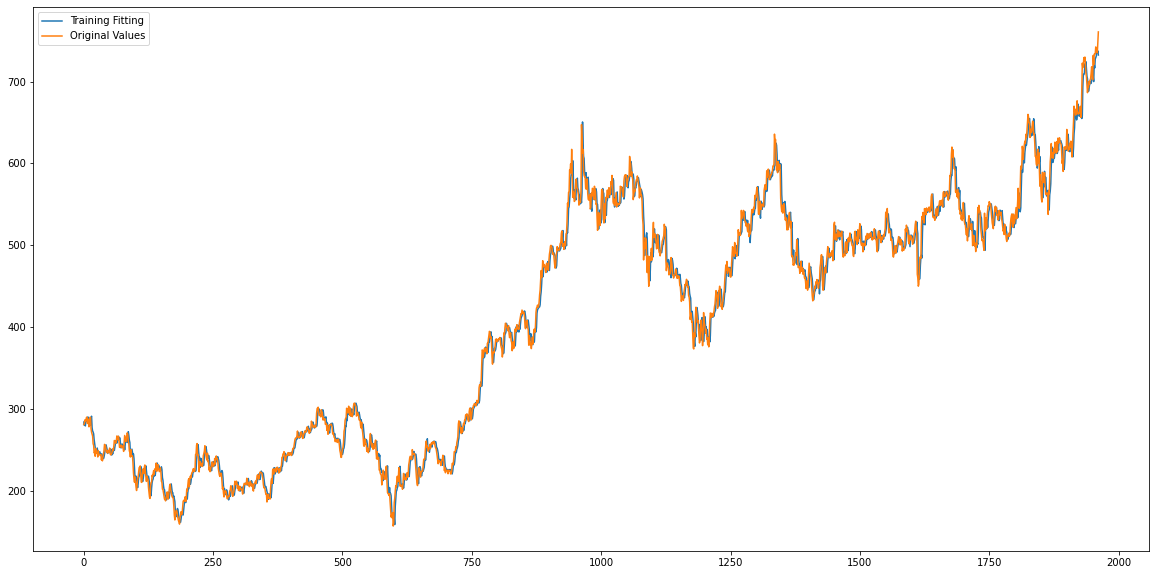

In [29]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(training_predictions) , label='Training Fitting')
plt.plot(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,label='Original Values')
plt.legend()
plt.show()

As we can see above training is done wonderfully. And model learned training data very precisely , and we can use this model for prediction .

But first let's check over testing data

## Model's Testing

In [83]:
preds = lstm.predict(X_test)

In [84]:
print('Mean Squared Error : {}'.format(mean_squared_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,scaler.inverse_transform(preds) )))
print('Mean Absolute Error : {}'.format(mean_absolute_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,scaler.inverse_transform(preds))))

Mean Squared Error : 550.2183783052908
Mean Absolute Error : 16.713870547862538


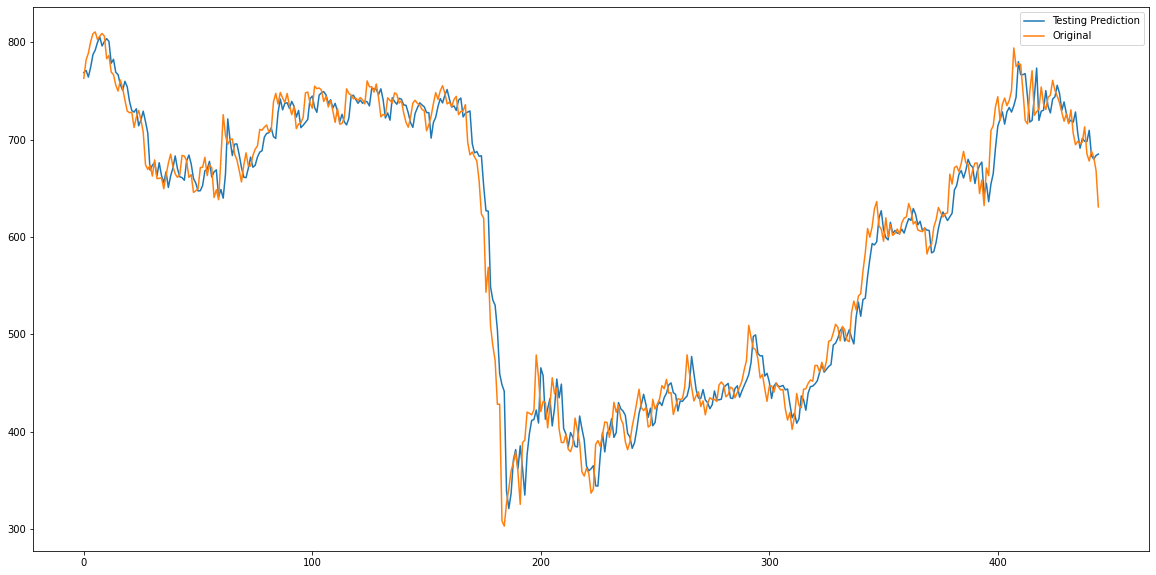

In [85]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(preds) , label='Testing Prediction')
plt.plot(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,label='Original')
plt.legend()
plt.show()

Great !! Model preforms very good for predicting values . But have some difference in accuracy or say error .

**Let's prepare this output for human readable csv format**

In [88]:
scaled_original = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
scaled_lstm = scaler.inverse_transform(preds)

In [89]:
scaled_original = scaled_original.reshape(1,-1).tolist()
scaled_lstm  = scaled_lstm.reshape(1,-1).tolist()

In [90]:
index = test[61:].index

In [91]:
data = {'Original':scaled_original[0] ,
        'Prediction': scaled_lstm[0]}

In [92]:
df = pd.DataFrame(data=data , index =index)

In [93]:
df.loc['2021-01':]

,Original,Prediction
Date,,
2021-01-01,623.799988,621.387756
2021-01-04,624.700012,616.775757
2021-01-05,664.450012,620.658325
2021-01-06,654.250000,624.411377
2021-01-07,671.099976,648.139404
...,...,...
2021-04-06,677.900024,709.455261
2021-04-07,688.250000,683.223511
2021-04-08,681.599976,679.908325


In [94]:
df.to_csv('./axisbankPredictions.csv')

**Let's check some more metrices**

In [95]:
print('Mean Absolute Percentage Error : {}'.format(mean_absolute_percentage_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,scaler.inverse_transform(preds) )))

Mean Absolute Percentage Error : 0.031044166207405806


In [96]:
print('Mean Absolute Percentage Error : {}'.format(mean_absolute_percentage_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,scaler.inverse_transform(training_predictions) )))

Mean Absolute Percentage Error : 0.023357430297662216


**Visualize the data in scatter plot which makes it more insightfull for us.**

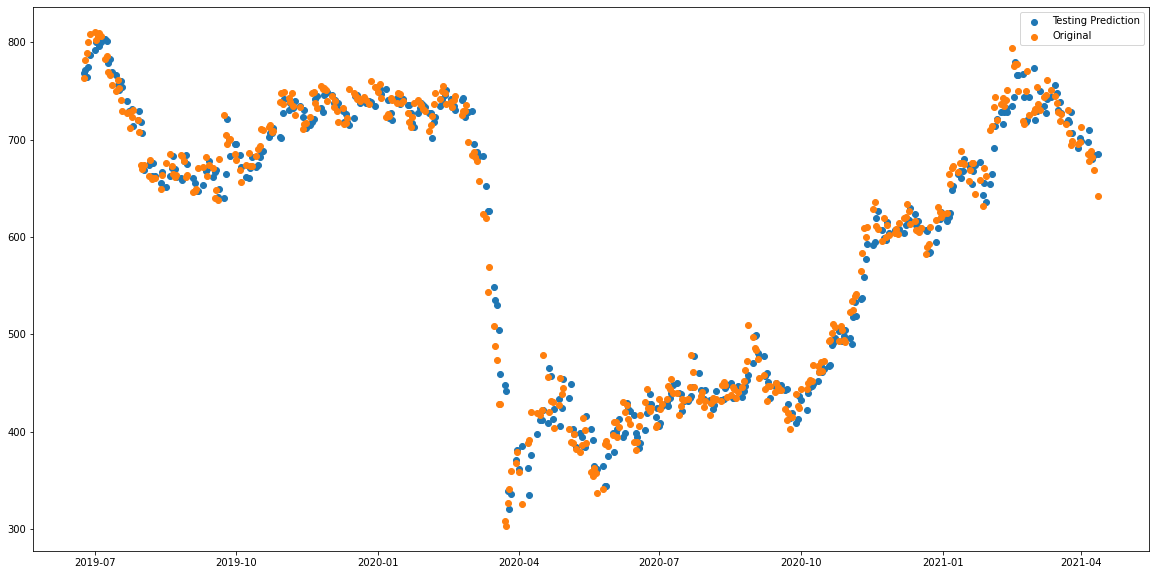

In [38]:
plt.figure(figsize=(20,10))
plt.scatter(index , scaler.inverse_transform(preds) , label='Testing Prediction')
plt.scatter(index , scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,label='Original')
plt.legend()
plt.show()

In [99]:
df['pct_change_original']= df['Original'].pct_change()
df['pct_change_predicted']= df['Prediction'].pct_change()
df['Error'] = df['Original'] - df['Prediction']

In [100]:
df.head()

,Original,Prediction,pct_change_original,pct_change_predicted,Error
Date,,,,,
2019-06-24,762.849976,768.689026,NaN,NaN,-5.839050
2019-06-25,781.650024,770.903381,0.024644,0.002881,10.746643
2019-06-26,788.599976,764.104004,0.008891,-0.008820,24.495972
2019-06-27,800.450012,774.221252,0.015027,0.013241,26.228760
2019-06-28,808.549988,787.142517,0.010119,0.016689,21.407471


85.7366943359375
-139.693603515625


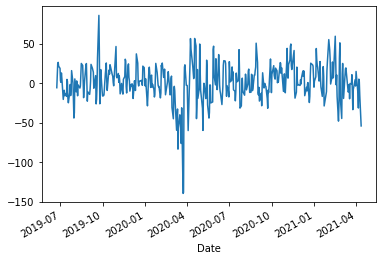

In [101]:
print(df['Error'].max())
print(df['Error'].min())
df['Error'].plot()
plt.show()

**As We can see max difference is of 139 points which is quite large. Let's see on which date this error is coming**

In [116]:
df['Error'][np.abs(df['Error'])> 30]

Date
2019-07-31   -44.251892
2019-08-01   -37.395874
2019-09-20    31.673462
2019-09-23    85.736694
2019-09-24    39.929993
                ...    
2021-02-25    50.973267
2021-03-01   -44.784790
2021-03-25   -33.630920
2021-04-06   -31.555237
2021-04-12   -54.224792
Name: Error, Length: 61, dtype: float64

As we can see above mostly more than 30 points error comes only in pendamic time or say FEB , MARCH and APRIL of 2020. So this is quite good model.

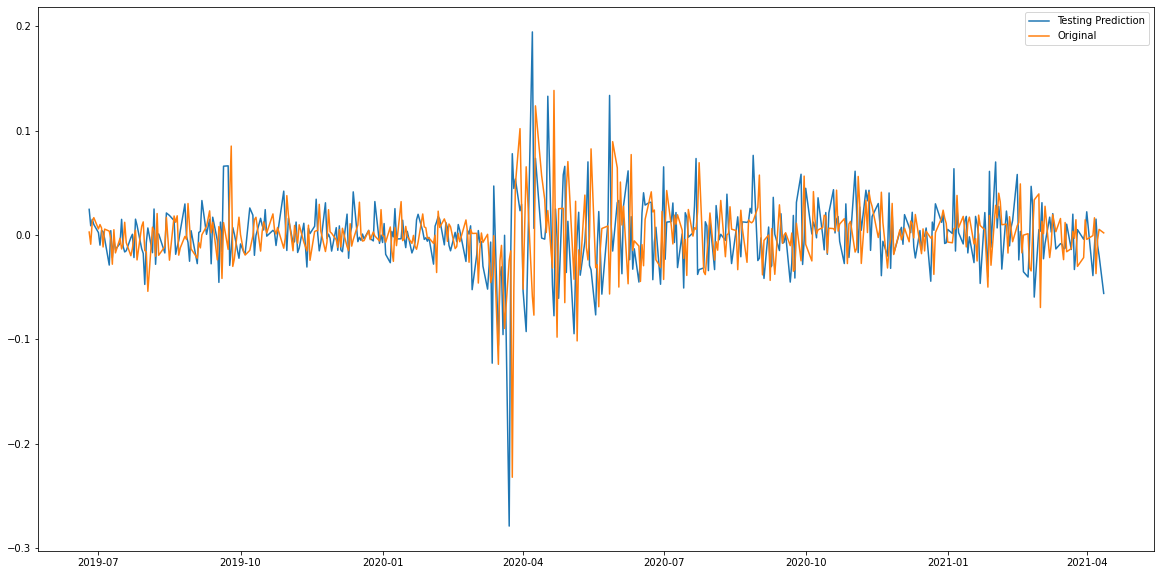

In [117]:
plt.figure(figsize=(20,10))
plt.plot(index , df['pct_change_original'] , label='Testing Prediction')
plt.plot(index , df['pct_change_predicted'] ,label='Original')
plt.legend()
plt.show()

As we can see in above plot there is not huge much difference in percentage change

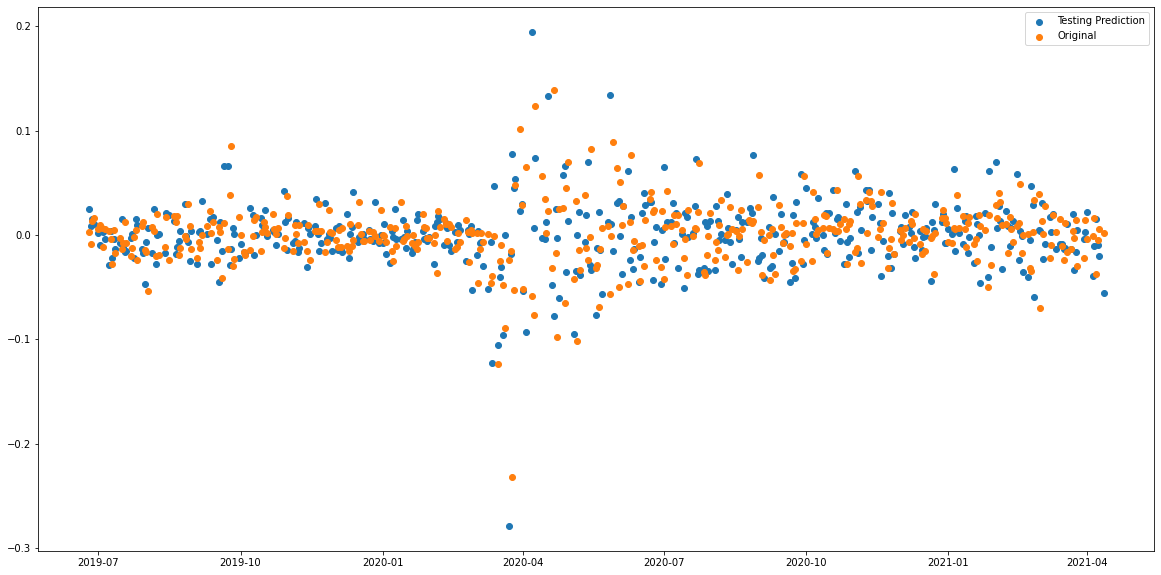

In [118]:
plt.figure(figsize=(20,10))
plt.scatter(index , df['pct_change_original'] , label='Testing Prediction')
plt.scatter(index , df['pct_change_predicted'] ,label='Original')
plt.legend()
plt.show()

# Done 